# Load data

In [1]:
import open3d as o3d

In [2]:
from glob import glob
import numpy as np

import sys
from ocamcamera import OcamCamera

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (16, 16)
# plt.rcParams['figure.figsize'] = (8, 6)

%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms

ToTensor = transforms.ToTensor()
ToPIL = transforms.ToPILImage()

In [4]:
def spherical_grid(h, w):
    """ Generate meshgrid for equirectangular projection.
    
    Parameters
    ----------
    h : int
        height of the expected equirectangular image
    w : int
        width of the expected equirectangular image
    
    Returns
    -------
    phi_xy : numpy array
        phi value (-np.pi < phi < np.pi)
    theta_xy : numpy array
        theta value (-np.pi/2 < phi < np.pi/2)
    """
    p = 2*np.pi/w
    th = np.pi/h
    phi = [-np.pi + (i+0.5)*p for i in range(w)]
    theta = [-np.pi/2 + (i+0.5)*th for i in range(h)]
    phi_xy, theta_xy  = np.meshgrid(phi, theta, sparse=False, indexing='xy')
    return phi_xy, theta_xy

In [5]:
# from scipy.io import loadmat
# params = loadmat('DATASET/omnimvs/omnithings/intrinsic_extrinsic.mat')
# params['ocams']

## Change file name
Some filenames are f'{i:04}.png', but almost all are f'{i:05}.png'

In [6]:
root_dir = '../datasets/omnithings/'
# root_dir = '../datasets/omnihouse'
# root_dir = '../datasets/urban/sunny'

from glob import glob
from os.path import join

imgfiles = {}
# load image filename
cam_list = ['cam1', 'cam2', 'cam3', 'cam4']
for cam in cam_list:
#     imgfiles[cam] = sorted(glob(join(root_dir, cam, '*.png')))
    imgfiles[cam] = sorted(glob(join(root_dir, cam, '*.png')))
for i in range(1,5):
    print(f'cam{i}')
    print(len(imgfiles[f'cam{i}']))

cam1
10240
cam2
10240
cam3
10240
cam4
10240


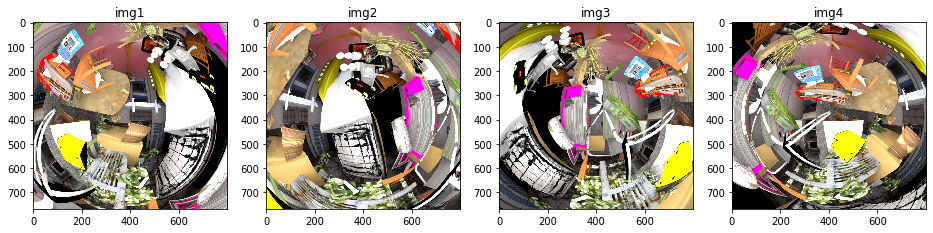

In [7]:
imgs = []
for i in range(1,5):
    img_file = imgfiles[f'cam{i}'][0]
    imgs.append(cv2.imread(img_file)[:,:,::-1])

fig, ax = plt.subplots(1, 4, figsize=(16,10))
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    ax[i].set_title(f'img{i+1}')

# Camera pose
poses.txt: 6-dof extrinsic of 4 cameras [rot_x rot_y rot_z tr_x tr_y tr_z]  
intrinsic_extrinsic.mat: matlab data file for the params  
convert unit from cm? to m for camera translation

In [8]:
from scipy.spatial.transform import Rotation as Rot
pose_file = join(root_dir, 'poses.txt')
poses = []
Tcw = []
with open(pose_file) as f:
    data = f.readlines()
    
# calculate pose T \in SE(3)
for it in data:
    it = list(map(float, it.split()))
    print(it)
    T = np.eye(4)
    angle = it[:3]
    R = Rot.from_rotvec(angle).as_matrix()
    T[:3,:3] = R
    T[:3, 3] = it[3:]
    T[:3, 3] /= 100  # from cm? to m
    poses.append(T)
    Tcw.append(np.linalg.inv(T))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.570796326794897, 0.0, 20.0, 0.0, -20.0]
[0.0, 3.141592653589793, 0.0, 0.0, 0.0, -40.0]
[0.0, -1.570796326794897, 0.0, -20.0, 0.0, -20.0]


In [9]:
def drawAxis(T=np.eye(4) ,scale=0.3, colors=['r', 'g', 'b']):
    tvec = T[:3,3]
    R = T[:3,:3]
    start = tvec.flatten()[np.newaxis].repeat(3, axis=0)
    end = start + scale * R.T
    for s, e, c in zip(start, end, colors):
        ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c=c)
        
%matplotlib notebook

<IPython.core.display.Javascript object>


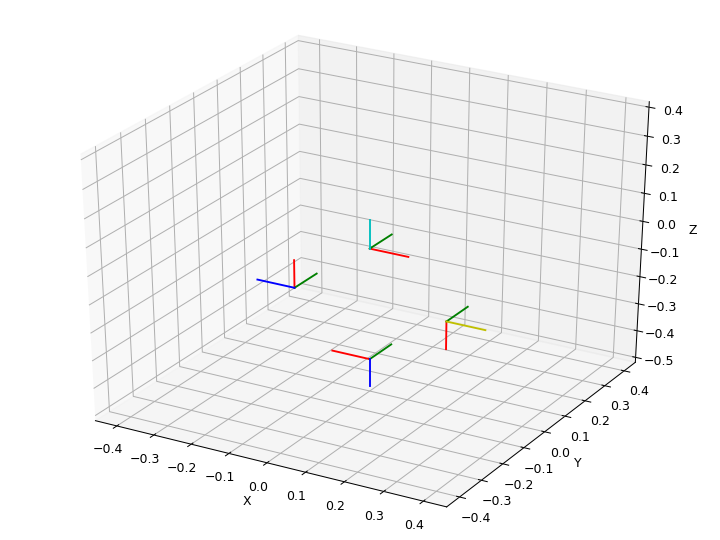

In [10]:
%matplotlib notebook
# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.axis('off')
c = ['c', 'y', 'b', 'b']

# Camera
for i, T in enumerate(poses):
    colors = ['r', 'g', c[i]]
    drawAxis(T, 0.1, colors)

# # Origin
# drawAxis(scale=10)

# adjust scale
start = np.zeros((3, 3)) - 0.4
end = start + 0.8 * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c='none')

# Ocam undistortion

In [11]:
%matplotlib inline

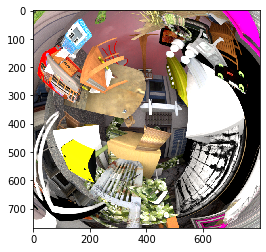

In [12]:
i = 1
fov = 220
key = f'cam{i}'
ocam_file = join(root_dir, f'o{key}.txt')
img_file = imgfiles[key][0]
img = cv2.imread(img_file)[:,:,::-1]
ocam = OcamCamera(ocam_file, fov)
plt.imshow(img)

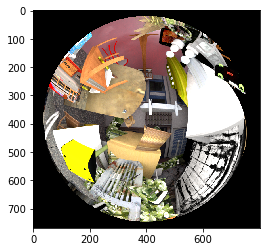

In [13]:
# limit area by FoV
valid = ocam.valid_area()
img[valid==0] = 0
plt.imshow(img)

## Perspecive projection

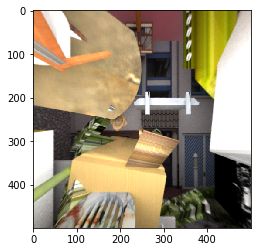

In [14]:
W = 500
H = 500
z = W/3.0
x = [i-W/2 for i in range(W)]
y = [j-H/2 for j in range(H)]
x_grid, y_grid = np.meshgrid(x, y, sparse=False, indexing='xy')
point3D = np.stack([x_grid, y_grid, np.full_like(x_grid, z)]).reshape(3, -1)
mapx, mapy = ocam.world2cam(point3D)
mapx = mapx.reshape(H, W)
mapy = mapy.reshape(H, W)
out = cv2.remap(img, mapx, mapy,cv2.INTER_LINEAR)
plt.imshow(out)

## Equirectangular projection
### numpy

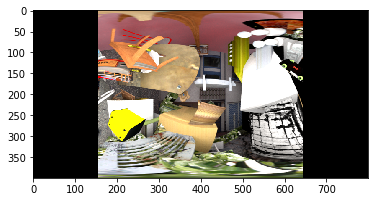

In [15]:
W = 800
H = 400
fov = 220
fov_rad = np.deg2rad(fov/2)
phi_xy, theta_xy  = spherical_grid(H, W)
flag = np.all([np.abs(phi_xy)<fov_rad, np.abs(theta_xy)<fov_rad], axis=0)

point3D = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)]).reshape(3, -1)
mapx, mapy = ocam.world2cam(point3D)
mapx = mapx.reshape(H, W)
mapy = mapy.reshape(H, W)
out = cv2.remap(img, mapx, mapy,cv2.INTER_LINEAR)
out[~flag]=0
plt.imshow(out)

### pytorch grid_sample


In [16]:
img = img.copy()

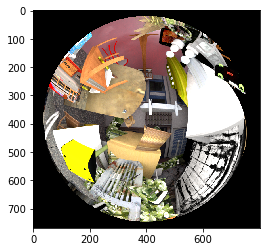

In [17]:
tensor = ToTensor(img)
plt.imshow(ToPIL(tensor))

In [18]:
# h, w = tensor.shape[1:]
# x = np.linspace(-1, 1, w) + 0.5
# y = np.linspace(-1, 1, h)
# xidx,yidx = np.meshgrid(x, y, sparse=False, indexing='xy')
# grid = np.stack([xidx, yidx], axis=-1)
# grid = torch.from_numpy(grid.astype(np.float32))
# out = F.grid_sample(tensor.unsqueeze(0), grid.unsqueeze(0))
# plt.imshow(ToPIL(out[0]))

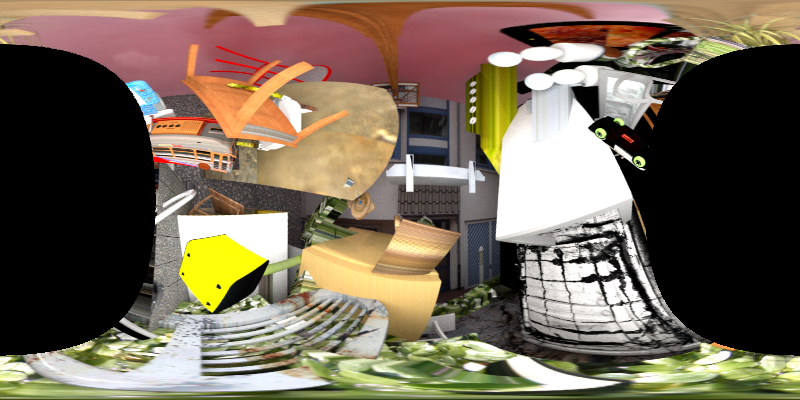

In [19]:
W = 800
H = 400
fov = 360
fov_rad = np.deg2rad(fov/2)
_, iH, iW = tensor.shape

phi_xy, theta_xy  = spherical_grid(H, W)
flag = np.all([np.abs(phi_xy)<fov_rad, np.abs(theta_xy)<fov_rad], axis=0)

point3D = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)]).reshape(3, -1)
mapx, mapy = ocam.world2cam(point3D)
mapx = mapx.reshape(H, W)
mapy = mapy.reshape(H, W)
mapx = 2*mapx/iW - 1
mapy = 2*mapy/iH - 1

# out of fov
mapx[~flag]=-2
mapy[~flag]=-2
grid = torch.from_numpy(np.stack([mapx, mapy], axis=-1))
out = F.grid_sample(tensor.unsqueeze(0), grid.unsqueeze(0), align_corners=False)
ToPIL(out[0])

## omnidirectional depth (depth from rig center)
value: 0 ~ 65500 inverse-depth index (should be divided by 100)
 - min_depth: 55
 - inverse depth: (value/100)/(min_depth*655) + eps
 
range: -\pi <= \theta <= \pi, -\pi/4 <= \phi <= \pi/4  
rig center: [0 0 -20] (arithmetic mean of camera positions)


In [20]:
def print_info(a):
    print(f'min:{a.min():.2f}, max:{a.max():.2f}, mean:{a.mean():.2f}, median:{np.median(a):.2f}')
    
def load_invdepth(filename, min_depth=55, urban=False):
    '''
    min_depth in [cm]
    '''
    invd_value = cv2.imread(filename, cv2.IMREAD_ANYDEPTH)
    invdepth = (invd_value/100.0)/(min_depth*655)+np.finfo(np.float32).eps
    invdepth *= 100 # unit conversion from cm to m
    
    if urban:
        tmp = np.zeros((320,640))+np.finfo(np.float32).eps
        tmp[80:80+160,:] = invdepth
        invdepth = tmp
    
    return invdepth

In [21]:
if 'urban' in root_dir: 
    depths = sorted(glob(join(root_dir, '../','depth_train_640/*.png')))
else:
    depths = sorted(glob(join(root_dir, 'depth_train_640/*.png')))
invd_value = cv2.imread(depths[0], cv2.IMREAD_ANYDEPTH)
print_info(invd_value)

min:0.00, max:51870.00, mean:8647.32, median:8072.00


In [22]:
depth_file = depths[0]
invdepth = load_invdepth(depth_file, urban='urban' in root_dir)

Depth info:
min:0.00, max:15.45, mean:5.71, median:4.46


/home/komatsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


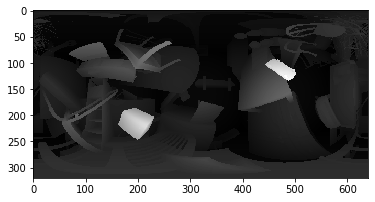

In [23]:
depth = 1/invdepth
depth[depth>100] = 0
print('Depth info:')
print_info(depth)
plt.imshow(1/depth)

## Visualize pointcloud

In [24]:
h, w = depth.shape[:2]
phi_xy, theta_xy  = spherical_grid(h, w)

pts = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)], axis=2)
pts = pts.reshape(-1, 3)*depth.reshape(-1, 1)

# Open3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts.reshape(-1, 3))
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6)
o3d.visualization.draw_geometries([pcd, origin])

# Sperical sweeping

## Add color on pointcloud
check the camera pose is correct

In [25]:
idx = 0 # scene idx
max_depth = 30
# estimate rig center
center = []
for it in poses:
    center.append(it[:3,3])
center = np.array(center).mean(axis=0)
print(center)

[ 0.   0.  -0.2]


../datasets/omnithings/depth_train_640/00001.png
min:0.00, max:15.45, mean:5.71, median:4.46
../datasets/omnithings/cam1/00001.png
../datasets/omnithings/cam2/00001.png
../datasets/omnithings/cam3/00001.png
../datasets/omnithings/cam4/00001.png


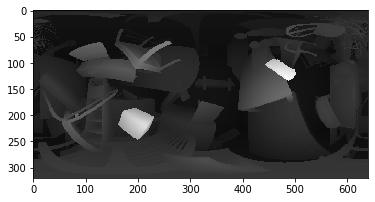

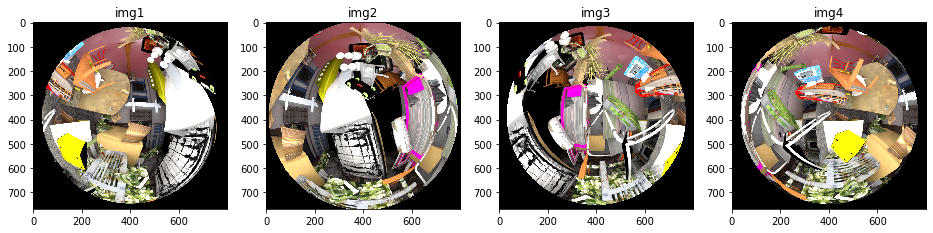

In [26]:
# load depth
print(depths[idx])
invdepth = load_invdepth(depths[idx], urban='urban' in root_dir)
depth = 1/invdepth
depth[depth>max_depth] = 0
print_info(depth)
plt.imshow(invdepth)

fov = 220
ocams = []
imgs = []
for i in range(1,5):
    key = f'cam{i}'
    ocam_file = join(root_dir, f'o{key}.txt')
    ocams.append(OcamCamera(ocam_file, fov, show_flag=False))
    imgs.append(cv2.imread(imgfiles[key][idx])[:,:,::-1])
    print(imgfiles[key][idx])
    # limit area by FoV
    valid = ocams[-1].valid_area()
    imgs[-1][valid==0] = 0
    
fig, ax = plt.subplots(1, 4, figsize=(16,10))
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    ax[i].set_title(f'img{i+1}')

In [27]:
cam_id = 0# camera index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


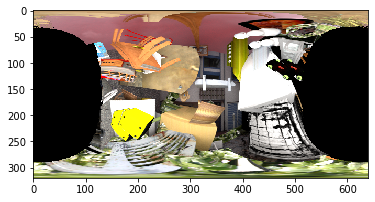

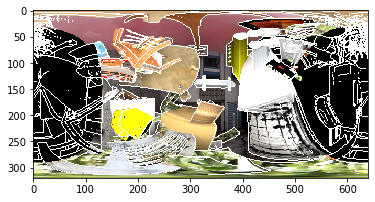

In [28]:
# sphere projection from rig center
h, w = depth.shape[:2]
phi_xy, theta_xy = spherical_grid(h, w)

pts = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)], axis=2)
# points from rig center
pts = pts.reshape(-1, 3)*depth.reshape(-1, 1)
pts += center

# add color from camera
# pt_c = T_cw*pt_w
pts_c = Tcw[cam_id][:3,:3].dot(pts.T)+Tcw[cam_id][:3, 3:4]
mapx, mapy = ocams[cam_id].world2cam(pts_c)
mapx = mapx.reshape(h, w)
mapy = mapy.reshape(h, w)
out = cv2.remap(imgs[cam_id], mapx, mapy,cv2.INTER_LINEAR)/255
plt.imshow(out)

# make sure if the depth match the color
plt.figure()
edge = np.abs(cv2.Laplacian(invdepth, cv2.CV_64F))>0.01
# plt.imshow(edge)
plt.imshow(out + edge[:,:,np.newaxis])

In [29]:
# Open3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(out.reshape(-1, 3))
# origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6)
origins = []
for T in Tcw:
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6)
    origin.transform(np.linalg.inv(T))
    origins.append(origin)
o3d.visualization.draw_geometries([pcd, *origins])

## sweeping
usnig pytorch

In [30]:
min_depth = 0.55 # minimum depth in m
ndisp = 192 # number of sweeping plane (sphere)

# sweeping plane
inv_depths = np.linspace(0, 1/min_depth, ndisp)[::2]

depth = 1/inv_depths[1]
print('depth:',depth)

depth: 52.525000000000006


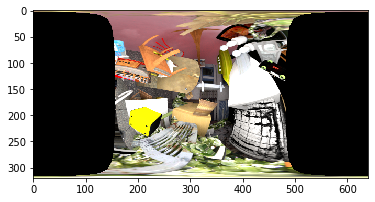

In [31]:
depth_value = 0.6
# spherical sweeping from rig center
h, w = 320, 640
phi_xy, theta_xy  = spherical_grid(h, w)

pts = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)], axis=2)
# points from rig center
pts = pts.reshape(-1, 3)*depth_value
pts += center

# add color from camera
# pt_c = T_cw*pt_w
pts_c = Tcw[cam_id][:3,:3].dot(pts.T)+Tcw[cam_id][:3, 3:4]
mapx, mapy = ocams[cam_id].world2cam(pts_c)
mapx = mapx.reshape(h, w)
mapy = mapy.reshape(h, w)
out = cv2.remap(imgs[cam_id], mapx, mapy,cv2.INTER_LINEAR)/255
plt.imshow(out)

## Spherical sweeping class

In [32]:
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def spherical_grid_3Dpoints(h, w):
    phi_xy, theta_xy  = spherical_grid(h, w)
    pts = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)], axis=2)
    return pts

@lru_cache(maxsize=None)
def spherical_sweep_grid(ocam, Tcw_bytes, center_bytes, depth, h=320, w=640):
    # numpy array is not hashable so give array as array.tobytes()
    Tcw = np.frombuffer(Tcw_bytes).reshape(4, 4)
    center = np.frombuffer(center_bytes)
    
    pts = spherical_grid_3Dpoints(h,w)
    # points from rig center
    pts = pts.reshape(-1, 3)*depth
    pts += center
    
    # add color from camera
    # pt_c = T_cw*pt_w
    pts_c = Tcw[:3,:3].dot(pts.T)+Tcw[:3, 3:4]
    mapx, mapy = ocam.world2cam(pts_c)
    
    # for grid_sample
    mapx = mapx.reshape(h, w)
    mapy = mapy.reshape(h, w)
    mapx = 2*mapx/ocam.width - 1
    mapy = 2*mapy/ocam.height - 1
    grid = torch.from_numpy(np.stack([mapx, mapy], axis=-1))
    return grid


In [33]:
from scipy.spatial.transform import Rotation as Rot
def load_poses(pose_file):
    """Calculate pose T cam <- world \in SE(3)"""
    Tcw = []
    with open(pose_file) as f:
        data = f.readlines()
        
    for it in data:
        it = list(map(float, it.split()))
        T = np.eye(4) # T world <- cam
        angle = it[:3]
        R = Rot.from_rotvec(angle).as_matrix()
        T[:3,:3] = R
        T[:3, 3] = it[3:]
        T[:3, 3] /= 100  # from cm to m
        Tcw.append(np.linalg.inv(T))
    return Tcw


class SphericalSweeping(object):
    def __init__(self, root_dir, fov=220):

        # load poses T cam <- world
        self.poses = load_poses(join(root_dir, 'poses.txt'))
        self.Tcw_bytes = [T.tobytes() for T in self.poses]

        # estimate rig center
        center = []
        for it in self.poses:
            center.append(it[:3, 3])
        center = np.array(center).mean(axis=0)
        self.center = center
        self.center_bytes = center.tobytes()

        # load ocam calibration data
        self.ocams = []
        for i in range(1, 5):
            key = f'cam{i}'
            ocam_file = join(root_dir, f'o{key}.txt')
            self.ocams.append(OcamCamera(ocam_file, fov, show_flag=False))

    def get_grid(self, idx, depth):
        grid = spherical_sweep_grid(self.ocams[idx], self.Tcw_bytes[idx], self.center_bytes, depth)
        return grid

In [34]:
sweep = SphericalSweeping(root_dir)

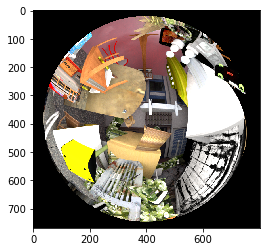

In [35]:
# cam_id = 2
tensor = ToTensor(imgs[cam_id].copy())
plt.imshow(ToPIL(tensor))

In [36]:
depth_value = 10
grid = sweep.get_grid(cam_id, depth_value)

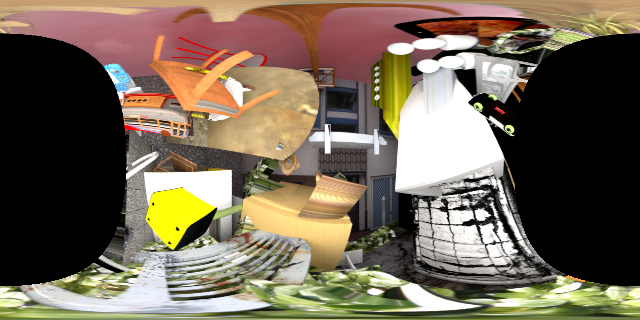

In [37]:
out = F.grid_sample(tensor.unsqueeze(0), grid.unsqueeze(0), align_corners=False)
ToPIL(out[0])